In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_processed = data_dir / 'processed'
data_raw = r'Y:\coskun-lab\Shuangyi\ERK, YAP project_2022\VP drug effect on HCC827 cells'


In [4]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
df_imgs_path = data_dir /'VP_drug2' /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)

# Generate scatter plot

In [6]:
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    df_ppi = df_ppi[df_ppi.Cyto!=0]
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [7]:
df_imgs

,Condition,FOV,Path
0,10uM,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
1,1uM,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
2,ctrl,FW1,y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...


In [8]:
# Read PPI
PPI_save_path = data_dir / 'VP_drug2' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Read masks 
masks_folder = data_dir / 'VP_drug2' / 'imgs' / 'masks_filtered'

In [9]:
df.PPI.unique()

array(['TEAD1/YAP', 'EGFR/Grb2', 'Trail/DR5', 'Sox2/Oct4',
       'E-cadherin/b-catenin'], dtype=object)

In [10]:
PPI_cycles = [['TEAD1/YAP'], [ 'EGFR/Grb2', 'Trail/DR5'], [ 'Sox2/Oct4'], [ 'E-cadherin/b-catenin']]

In [11]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Nuclei_Cell', 'Condition', 'FOV']


## 10uM

In [12]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                 10uM
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
Name: 0, dtype: object


In [13]:
image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 3762, 1933
x_max, y_max = 4365, 2388

DAPI_ch = 0

In [14]:
# # Get ppi location
# points = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, 'TEAD1/YAP') 

# # Napari viewerdd
# # Napari 
# viewer = napari.view_image(imgs[[0,list(markers).index('TEAD1/YAP')], y_min:y_max, x_min:x_max], channel_axis=0, colormap=['blue', 'magenta',], contrast_limits=[[0, 255], [0, 255]])
# points_layer = viewer.add_points(points, size=8,face_color='lime')

In [15]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta', 'Lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j], opacity=0.9)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)

    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'VP_10uM_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\2383855036.py:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_10uM_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\2383855036.py:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_10uM_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\2383855036.py:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_10uM_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\2383855036.py:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_10uM_{i}.tif', removeBorders(screenshot))


## 1uM

In [16]:
# Get images
index = 1
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                  1uM
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
Name: 1, dtype: object


In [17]:
# Define matching bbox to figures
x_min, y_min = 3680,1061
x_max, y_max = 4219,1517
DAPI_ch = 0

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta', 'Lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j], opacity=0.9)
    
    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'VP_1uM_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3070712749.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_1uM_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3070712749.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_1uM_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3070712749.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_1uM_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3070712749.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_1uM_{i}.tif', removeBorders(screenshot))


## Control

In [18]:
# Get images
index = 2
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']

mask_path = masks_folder / f'Cell_{row.Condition}_{row.FOV}.tif'
mask = skimage.io.imread(mask_path)

Condition                                                 ctrl
FOV                                                        FW1
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\VP_d...
Name: 2, dtype: object


In [19]:
# Define matching bbox to figures
x_min, y_min = 3077,1518
x_max, y_max = 3638,2013
DAPI_ch = 0

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]
mask_id = np.unique(mask[y_min:y_max, x_min:x_max])
color = {i: 'white' for i in mask_id if i != 0}

colors = ['magenta', 'Lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='cyan', contrast_limits=[0,200])
    label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color, opacity=0.9)
    label.contour = 2
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j], opacity=0.9)
    
    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'VP_ctrl_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3045620496.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3045620496.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3045620496.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_ctrl_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_48536\3045620496.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'VP_ctrl_{i}.tif', removeBorders(screenshot))


# Quantification

In [6]:
# Read PPI
PPI_save_path =  data_dir / 'VP_drug2' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei_Cell']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Nuclei', 'Count Nuclei']
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [7]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count        mean        std   min    25%  \
Condition PPI                                                               
10uM      E-cadherin/b-catenin  282.0   12.868794   8.311152   0.0   7.00   
          EGFR/Grb2             282.0    9.421986   6.415280   0.0   5.00   
          Sox2/Oct4             282.0   40.411348  23.233327   0.0  26.00   
          TEAD1/YAP             282.0  106.152482  59.580158   4.0  70.00   
          Trail/DR5             282.0   11.368794   7.264609   1.0   7.00   
1uM       E-cadherin/b-catenin  590.0    3.310169   3.252331   0.0   1.00   
          EGFR/Grb2             590.0    7.100000   4.897784   0.0   4.00   
          Sox2/Oct4             590.0   43.445763  21.702251   4.0  30.00   
          TEAD1/YAP             590.0   78.459322  48.071264  12.0  49.00   
          Trail/DR5             590.0    8.974576   5.920041   0.0   5.00   
ctrl      E-cadherin/b-catenin  510.0    1.468627   1.938645   0.0   0.00   
          EGFR/Grb2             510.0    6.468627   4.617171   0.0   3.00   
          Sox2/Oct4             510.0   44.013725  25.793989   0.0  28.25   
          TEAD1/YAP             510.0   76.037255  48.792820   6.0  49.00   
          Trail/DR5             510.0    7.856863   5.322701   0.0   4.00   

                                 50%     75%    max  
Condition PPI                                        
10uM      E-cadherin/b-catenin  11.5   17.00   45.0  
          EGFR/Grb2              8.0   12.75   50.0  
          Sox2/Oct4             37.0   50.00  189.0  
          TEAD1/YAP             90.5  132.00  438.0  
          Trail/DR5             10.0   14.00   60.0  
1uM       E-cadherin/b-catenin   2.0    5.00   17.0  
          EGFR/Grb2              6.0    9.00   64.0  
          Sox2/Oct4             39.0   53.00  229.0  
          TEAD1/YAP             68.0   92.00  460.0  
          Trail/DR5              8.0   11.00   60.0  
ctrl      E-cadherin/b-catenin   1.0    2.00   13.0  
          EGFR/Grb2              6.0    9.00   39.0  
          Sox2/Oct4             38.0   52.75  239.0  
          TEAD1/YAP             66.0   87.00  488.0  
          Trail/DR5              7.0   10.00   47.0

In [8]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 200

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

C:\Users\thu71\AppData\Local\Temp\ipykernel_699620\1821038392.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,1335.000000,1335.000000,1335.000000
mean,137.093633,62.955056,74.138577
std,57.288450,28.681147,39.836259
min,6.000000,0.000000,6.000000
25%,96.000000,47.000000,44.000000
50%,127.000000,61.000000,66.000000
75%,169.000000,76.500000,94.000000
max,398.000000,278.000000,288.000000


In [9]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

## Comparison between condition

In [39]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [40]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

df_all['Condition'] = df_all['Condition'].apply(lambda x: {'ctrl': 'Control'}.get(x, x))
df_all['Condition'].unique()

array(['10uM', '1uM', 'Control'], dtype=object)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_Control vs. Sox2/Oct4_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:4.228e-01 U_stat=1.383e+05
TEAD1/YAP_Control vs. TEAD1/YAP_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.592e-01 U_stat=1.353e+05
Trail/DR5_Control vs. Trail/DR5_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.567e-04 U_stat=1.233e+05
EGFR/Grb2_1uM vs. EGFR/Grb2_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.067e-06 U_stat=6.018e+04
Sox2/Oct4_1uM vs. Sox2/Oct4_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.341e-03 U_stat=8.652e+04
TEAD1/YAP_1uM vs. TEAD1/YAP_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.586e-15 U_stat=5.005e+04
Trail/DR5_1uM vs. Trail/DR5_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.418e-06 U_stat=6.035e+04
E-cadherin/b-catenin_Control vs. E-cadherin/b-catenin_1uM: Mann-

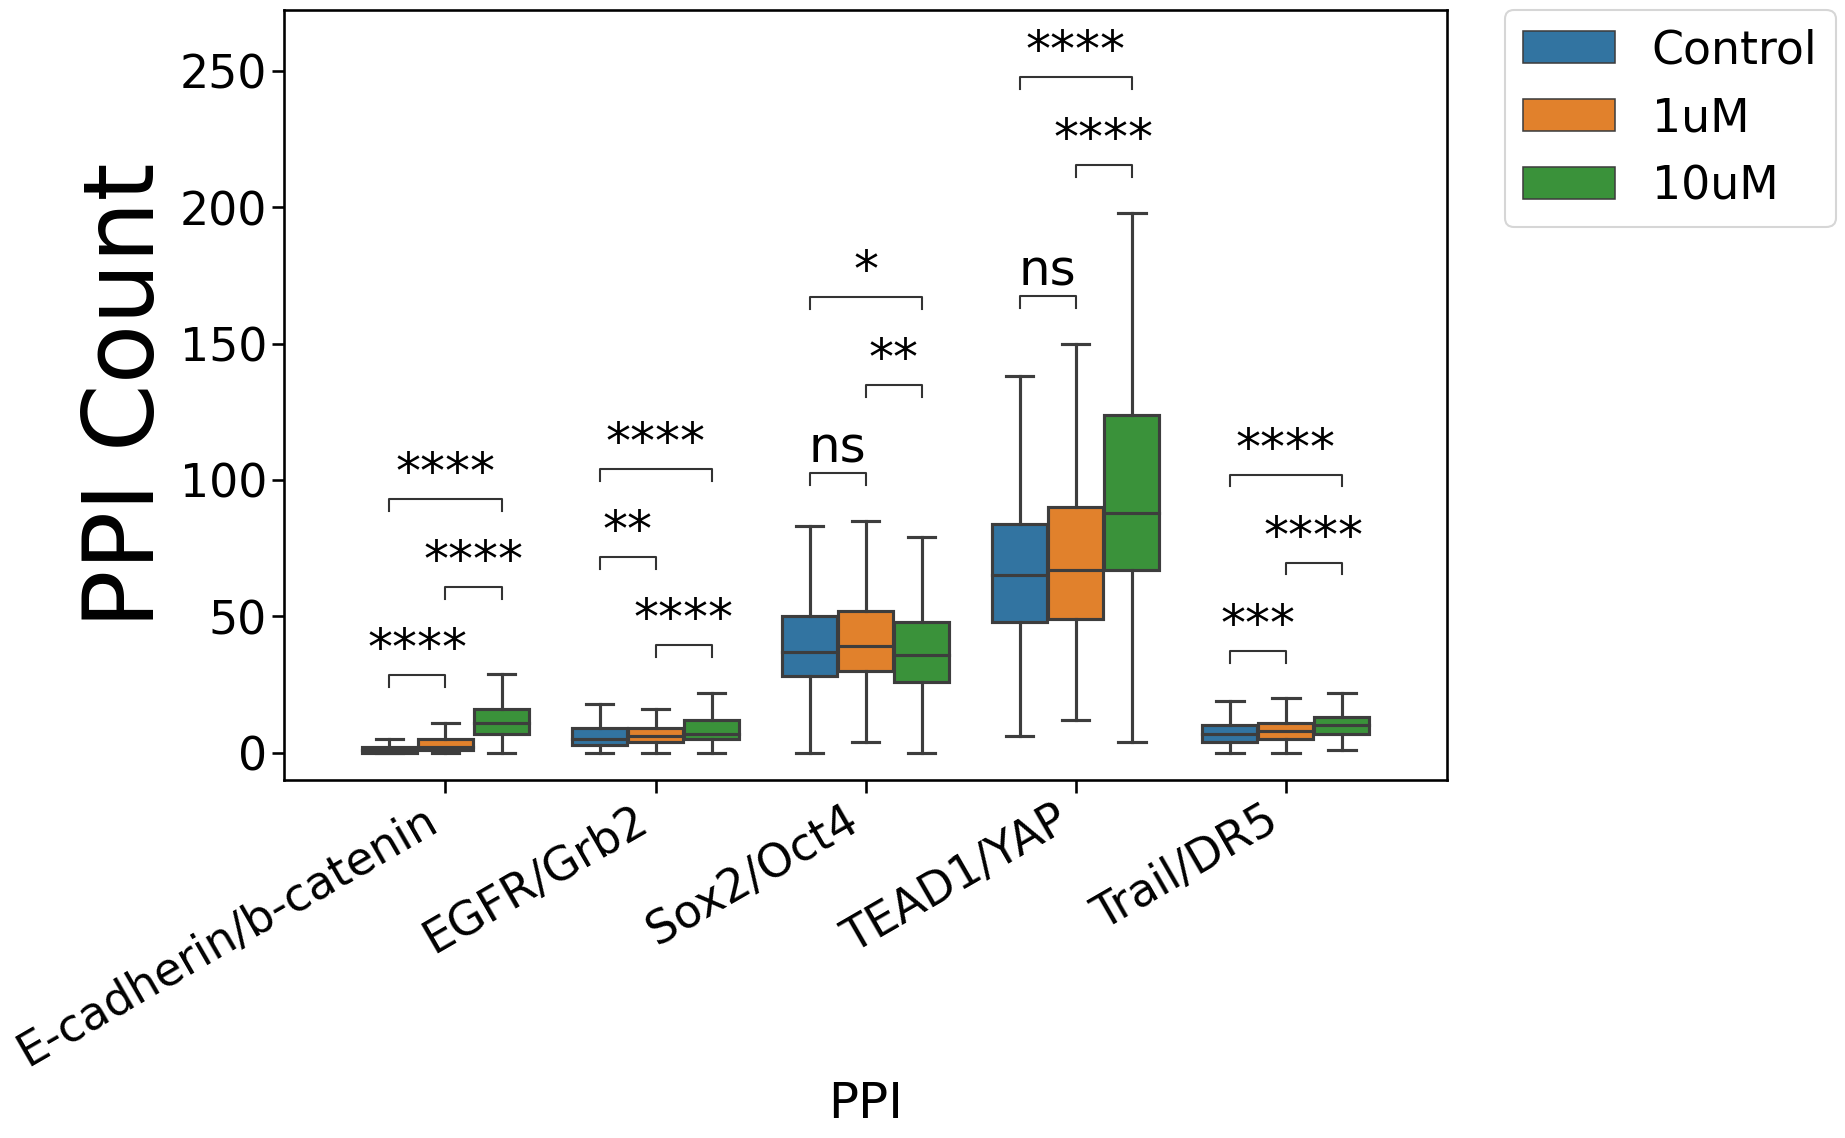

In [41]:
pairs = [((e, 'Control'), (e, '1uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, '1uM'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['Control', '1uM', '10uM'])
    annot = Annotator(ax, pairs, hue_order=['Control', '1uM', '10uM'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI Count', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_Control vs. Sox2/Oct4_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.590e-02 U_stat=1.302e+05
TEAD1/YAP_Control vs. TEAD1/YAP_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:7.151e-01 U_stat=1.405e+05
Trail/DR5_Control vs. Trail/DR5_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:5.227e-01 U_stat=1.392e+05
EGFR/Grb2_1uM vs. EGFR/Grb2_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.299e-06 U_stat=6.051e+04
Sox2/Oct4_1uM vs. Sox2/Oct4_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.166e-08 U_stat=9.466e+04
TEAD1/YAP_1uM vs. TEAD1/YAP_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.380e-03 U_stat=6.562e+04
Trail/DR5_1uM vs. Trail/DR5_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:3.035e-04 U_stat=6.438e+04
E-cadherin/b-catenin_Control vs. E-cadherin/b-catenin_1uM: Mann-

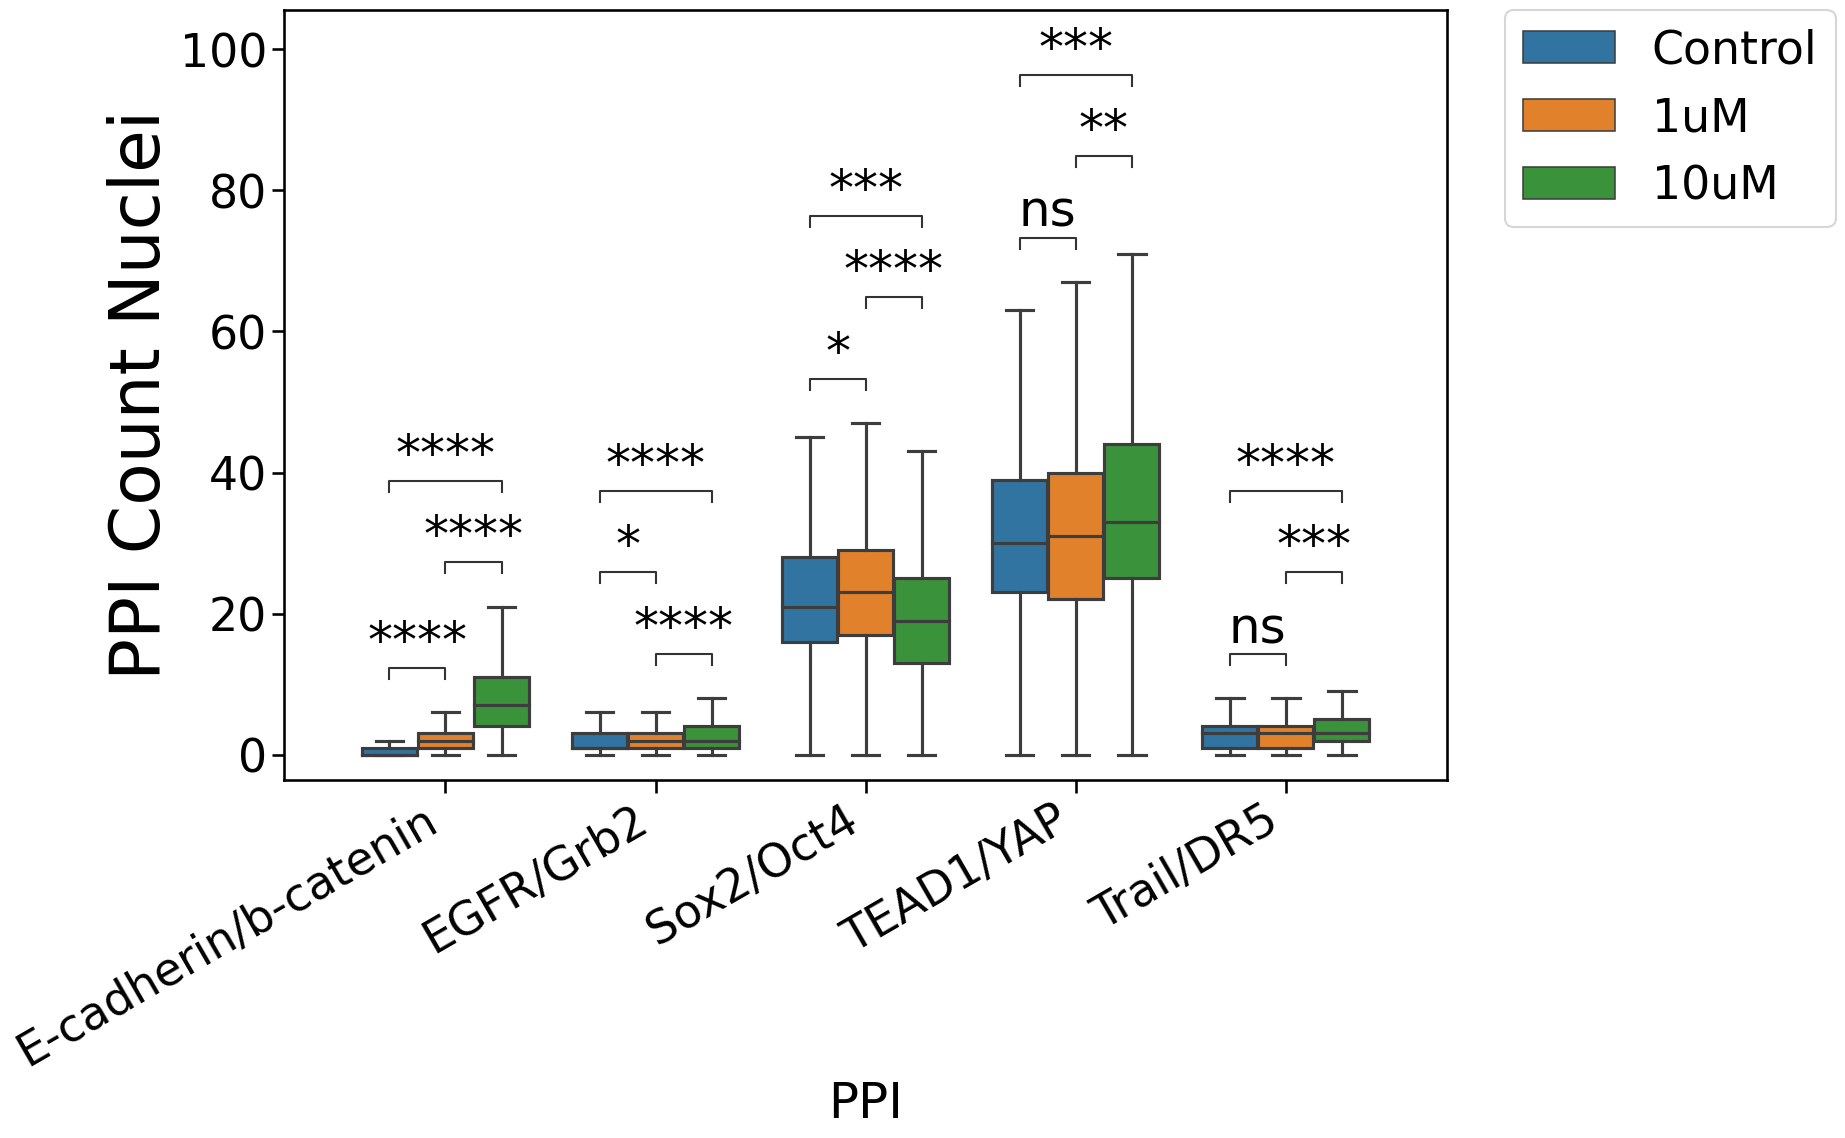

In [42]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

pairs = [((e, 'Control'), (e, '1uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, '1uM'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['Control', '1uM', '10uM'])
    annot = Annotator(ax, pairs, hue_order=['Control', '1uM', '10uM'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI Count Nuclei', fontsize=50)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [43]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_Control vs. Sox2/Oct4_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:3.474e-01 U_stat=1.471e+05
TEAD1/YAP_Control vs. TEAD1/YAP_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.152e-01 U_stat=1.344e+05
Trail/DR5_Control vs. Trail/DR5_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.758e-06 U_stat=1.184e+05
EGFR/Grb2_1uM vs. EGFR/Grb2_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:7.949e-04 U_stat=6.516e+04
Sox2/Oct4_1uM vs. Sox2/Oct4_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:7.189e-01 U_stat=7.723e+04
TEAD1/YAP_1uM vs. TEAD1/YAP_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:5.832e-18 U_stat=4.788e+04
Trail/DR5_1uM vs. Trail/DR5_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.748e-04 U_stat=6.386e+04
E-cadherin/b-catenin_Control vs. E-cadherin/b-catenin_1uM: Mann-

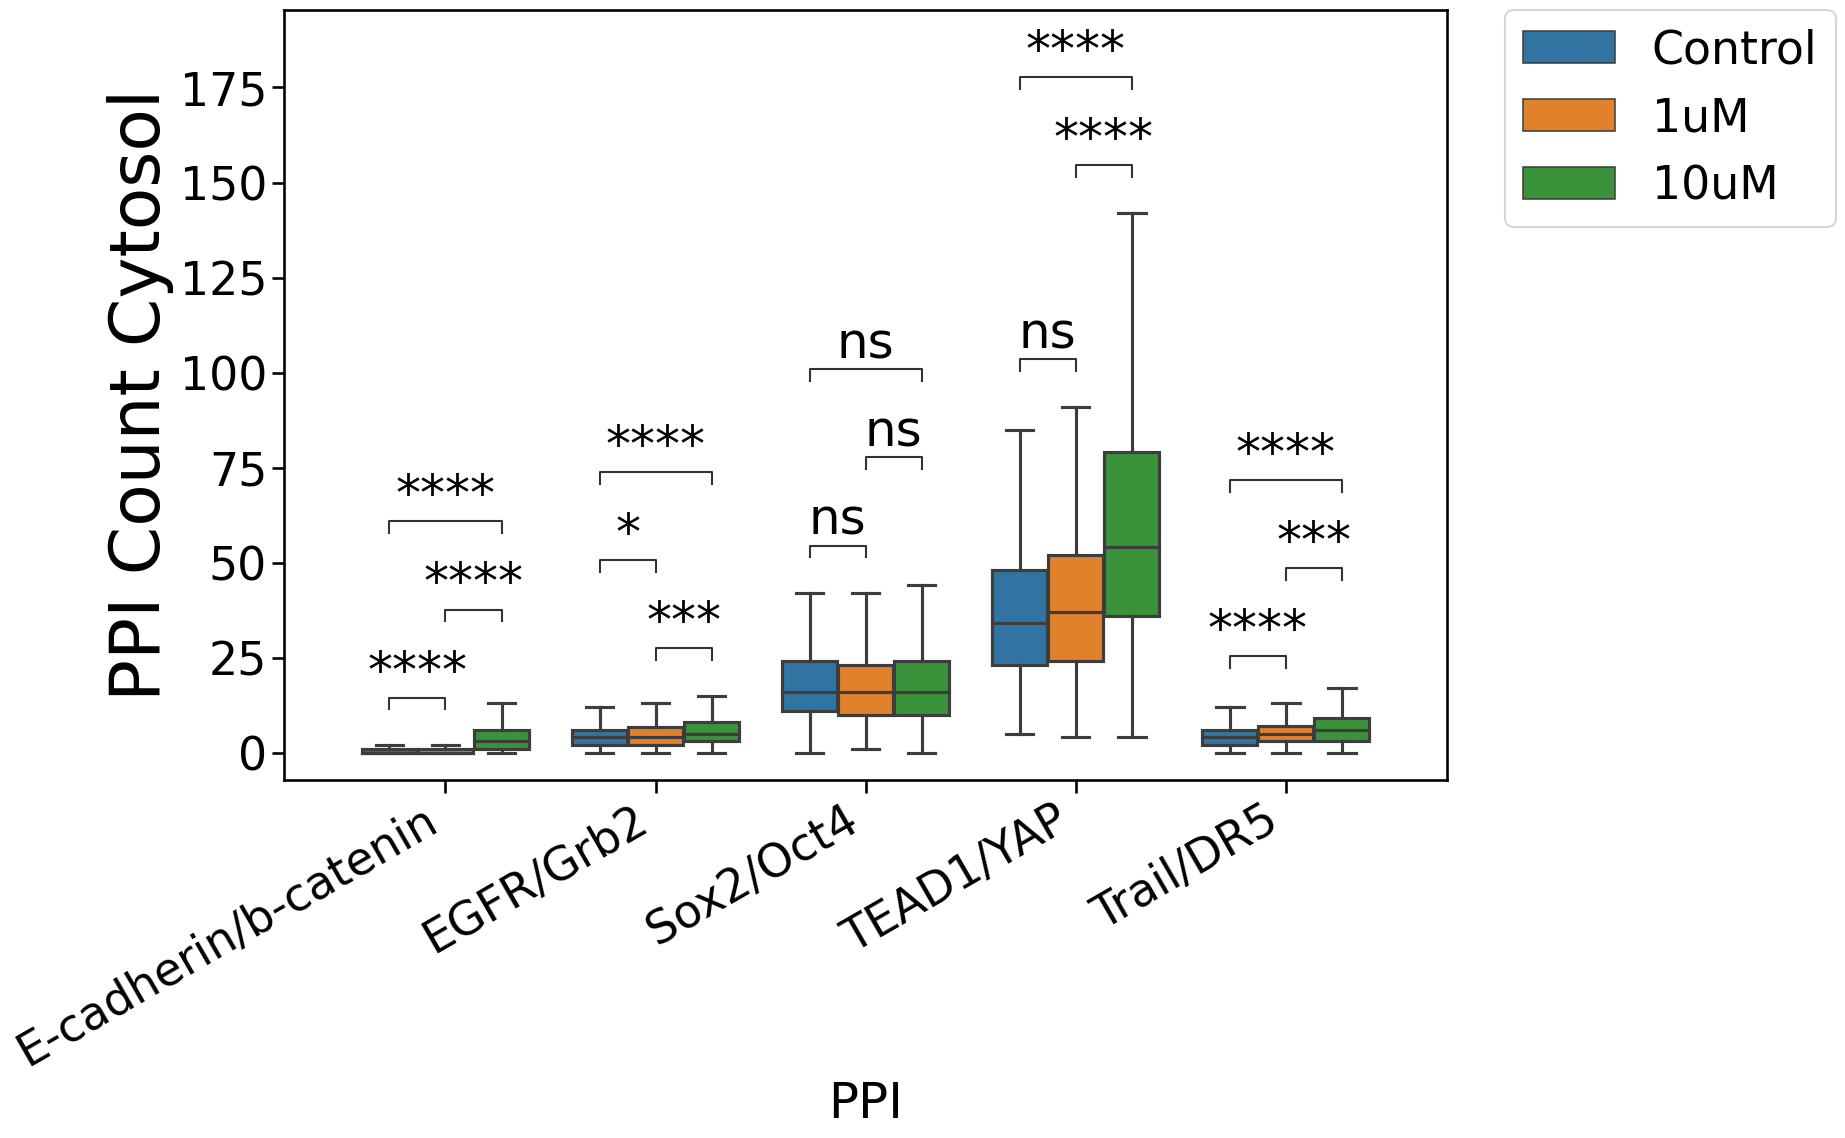

In [44]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

pairs = [((e, 'Control'), (e, '1uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, '1uM'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['Control', '1uM', '10uM'])
    annot = Annotator(ax, pairs, hue_order=['Control', '1uM', '10uM'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI Count Cytosol', fontsize=50)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [46]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

## Comparison of nuclei - cytosolic ratio

In [33]:
df_all['Ratio'] = df_all['Count_nuclei'].div(df_all['Count_cell'])


In [34]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Ratio",
    "hue": "Condition"
}



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_Control vs. Sox2/Oct4_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.205e-03 U_stat=1.258e+05
TEAD1/YAP_Control vs. TEAD1/YAP_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.992e-01 U_stat=1.488e+05
Trail/DR5_Control vs. Trail/DR5_1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.188e-03 U_stat=1.550e+05
EGFR/Grb2_1uM vs. EGFR/Grb2_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.449e-01 U_stat=6.895e+04
Sox2/Oct4_1uM vs. Sox2/Oct4_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.590e-04 U_stat=8.774e+04
TEAD1/YAP_1uM vs. TEAD1/YAP_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:3.582e-13 U_stat=9.978e+04
Trail/DR5_1uM vs. Trail/DR5_10uM: Mann-Whitney-Wilcoxon test two-sided, P_val:9.229e-01 U_stat=7.548e+04
E-cadherin/b-catenin_Control vs. E-cadherin/b-catenin_1uM: Mann-

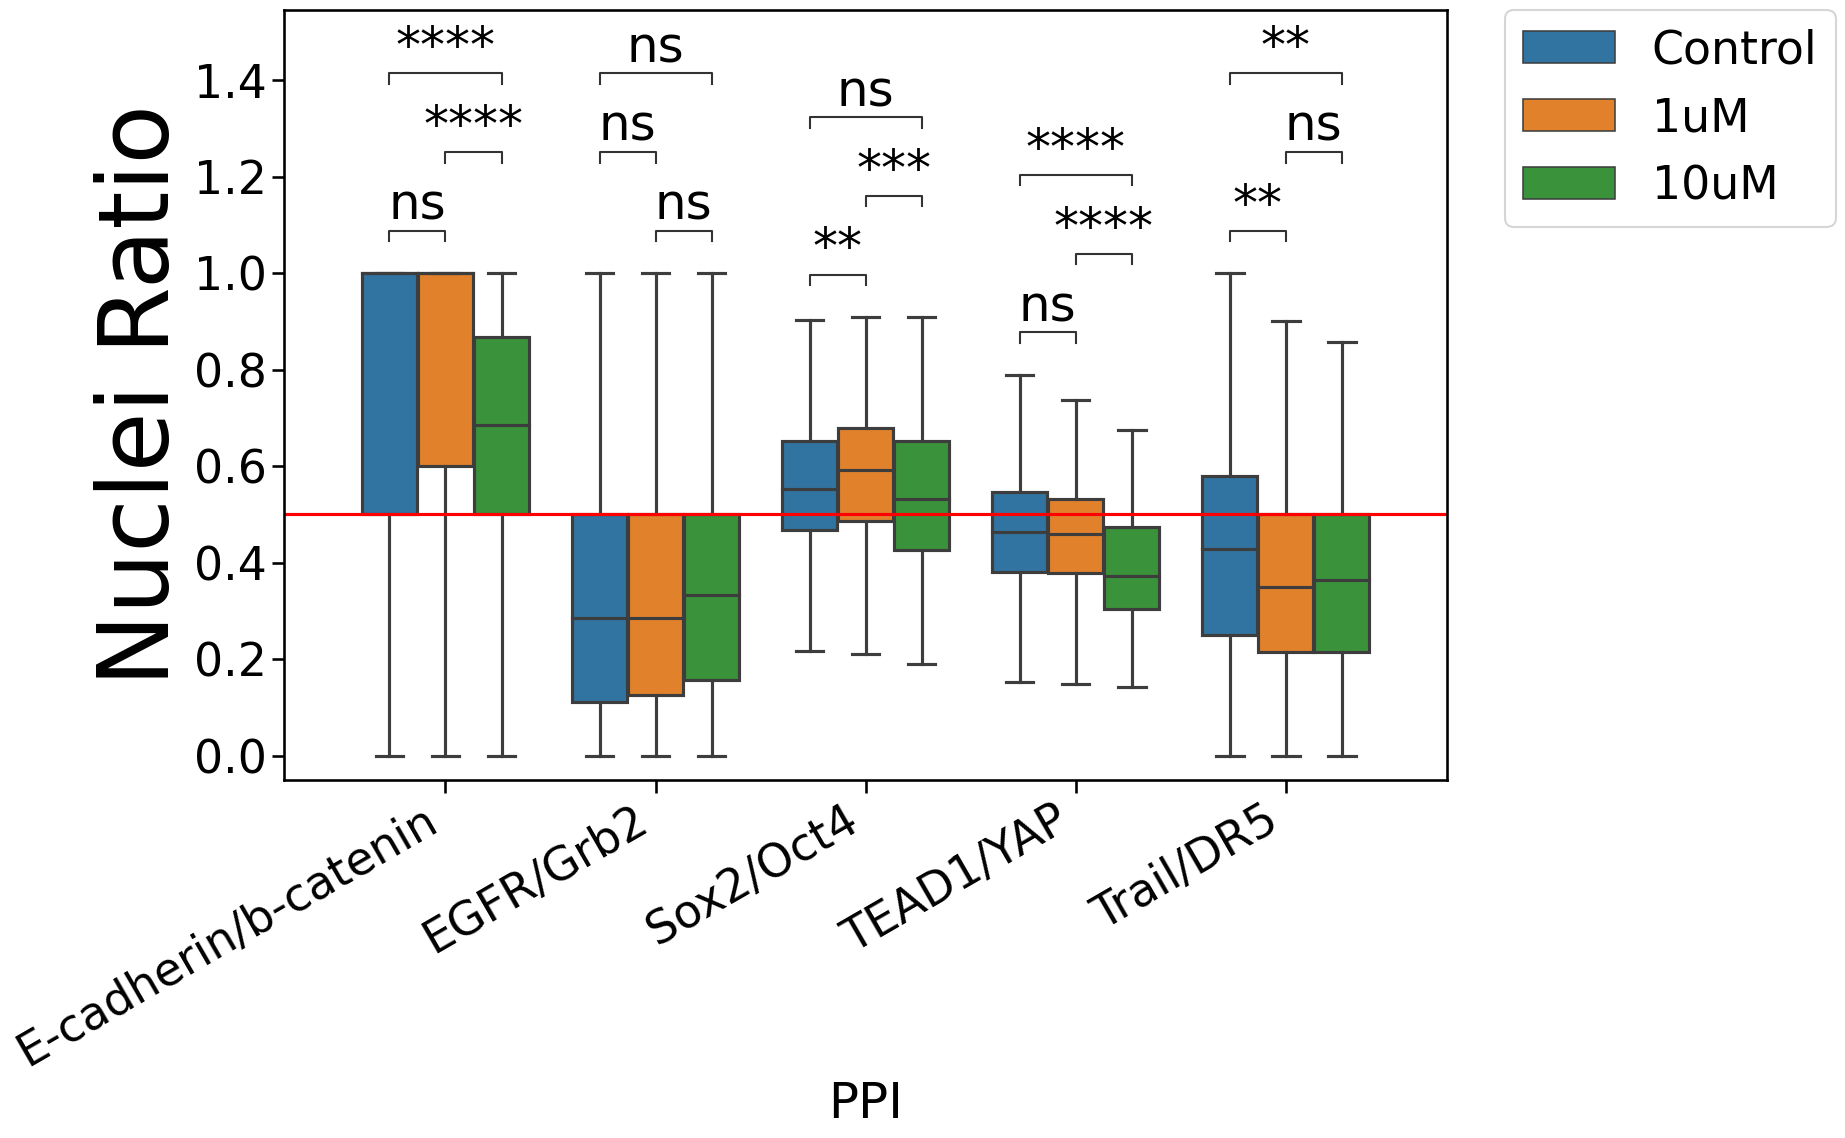

In [35]:
pairs = [((e, 'Control'), (e, '1uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Control'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, '1uM'), (e, '10uM')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['Control', '1uM', '10uM'])
    annot = Annotator(ax, pairs, hue_order=['Control', '1uM', '10uM'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('Nuclei Ratio', fontsize=70)
    ax.axhline(y = 0.5, color = 'r', linestyle = '-')
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [38]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

# Ki67 Ratio

In [18]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [19]:
# Get Co-expression data
PPI_exp_path =  data_dir / 'VP_drug2' / 'PPI' / 'expression'

df_Ki67 = pd.read_csv(PPI_exp_path / 'Ki67.csv', index_col=0)
df_Ki67['Ki67 Nuclei ratio'] = df_Ki67['Ki67 Area'].div(df_Ki67['Nuclei Area'])
df_Ki67['Condition'] = df_Ki67['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))

In [20]:
df_Ki67.groupby('Condition')['Ki67 Nuclei ratio'].describe().to_clipboard()

In [21]:
# Boxplot per cell
plotting = {
    "data": df_Ki67,
    "x": "Condition",
    "y": "Ki67 Nuclei ratio",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1uM vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:7.848e-01 U_stat=1.542e+05
10uM vs. 1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:2.245e-29 U_stat=1.334e+05
10uM vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.560e-24 U_stat=1.141e+05


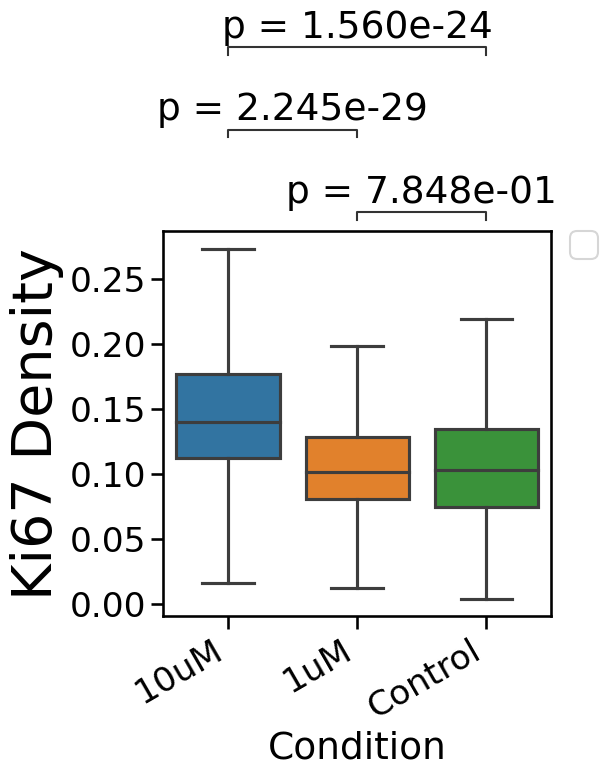

In [22]:
pairs = [('Control', '1uM'), ('Control', '10uM'), ('10uM', '1uM')]

with sns.plotting_context('talk', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='full', loc='outside', verbose=2, show_test_name=False)
    result = annot.apply_test().annotate()
    ax.set_ylabel('Ki67 Density', fontsize=40)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Intensity

In [23]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [24]:
# Get Co-expression data
PPI_exp_path =  data_dir / 'VP_drug2' / 'PPI' / 'expression'

df_Ki67 = pd.read_csv(PPI_exp_path / 'Ki67_intensity.csv', index_col=0)
df_Ki67['Condition'] = df_Ki67['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))

In [25]:
df_Ki67

,Cell,Area,Ki67,Condition
0,8,38907.0,12.138278,10uM
1,10,15708.0,7.348739,10uM
2,11,10365.0,15.865027,10uM
3,14,29638.0,3.150989,10uM
4,15,26603.0,7.771454,10uM
...,...,...,...,...
508,617,32728.0,2.413560,Control
509,618,15838.0,6.887549,Control
510,620,28077.0,11.681590,Control
511,621,33493.0,1.594333,Control


In [26]:
import seaborn as sns

# Boxplot per cell
plotting = {
    "data": df_Ki67,
    "x": "Condition",
    "y": "Ki67",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1uM vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:6.939e-05 U_stat=1.714e+05
10uM vs. 1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:9.507e-45 U_stat=1.320e+05
10uM vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:6.042e-54 U_stat=1.196e+05


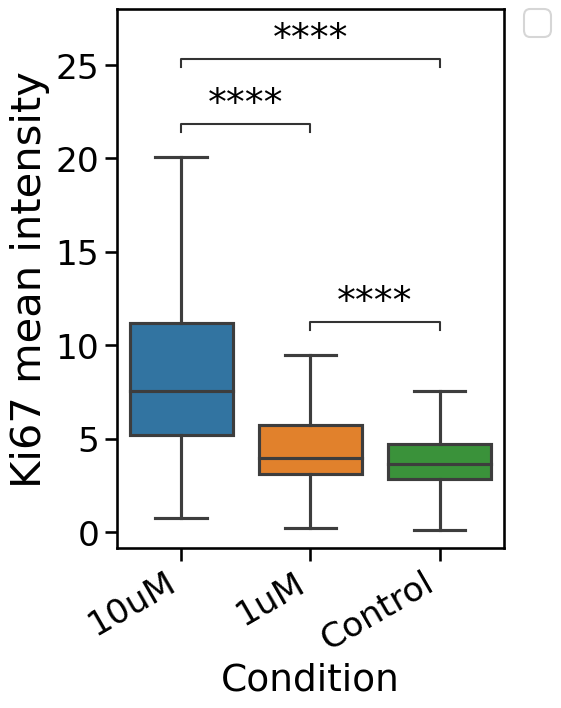

In [27]:
pairs = [('Control', '1uM'), ('Control', '10uM'), ('10uM', '1uM')]

with sns.plotting_context('talk', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(5,7))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('Ki67 mean intensity', fontsize=30)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Intensity

In [28]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [29]:
# Get Co-expression data
PPI_exp_path =  data_dir /'VP_drug2' / 'PPI' / 'expression'

df_Ki67 = pd.read_csv(PPI_exp_path / 'bcatenin_intensity.csv', index_col=0)
df_Ki67['Condition'] = df_Ki67['Condition'].apply(lambda x: {'ctrl': 'Control', 'O': 'Treated'}.get(x, x))

In [30]:
df_Ki67

,Cell,Area,E-cadherin/b-catenin,Condition
0,8,38907.0,52.069036,10uM
1,10,15708.0,41.231602,10uM
2,11,10365.0,47.662808,10uM
3,14,29638.0,11.676260,10uM
4,15,26603.0,29.028756,10uM
...,...,...,...,...
508,617,32728.0,8.806924,Control
509,618,15838.0,26.462116,Control
510,620,28077.0,34.124978,Control
511,621,33493.0,6.475592,Control


In [31]:
# Boxplot per cell
plotting = {
    "data": df_Ki67,
    "x": "Condition",
    "y": "E-cadherin/b-catenin",
}

In [32]:
plotting['data'].groupby(plotting['x'])[plotting['y']].describe().to_clipboard()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1uM vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.271e-08 U_stat=1.803e+05
10uM vs. 1uM: Mann-Whitney-Wilcoxon test two-sided, P_val:7.763e-68 U_stat=1.437e+05
10uM vs. Control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.067e-73 U_stat=1.279e+05


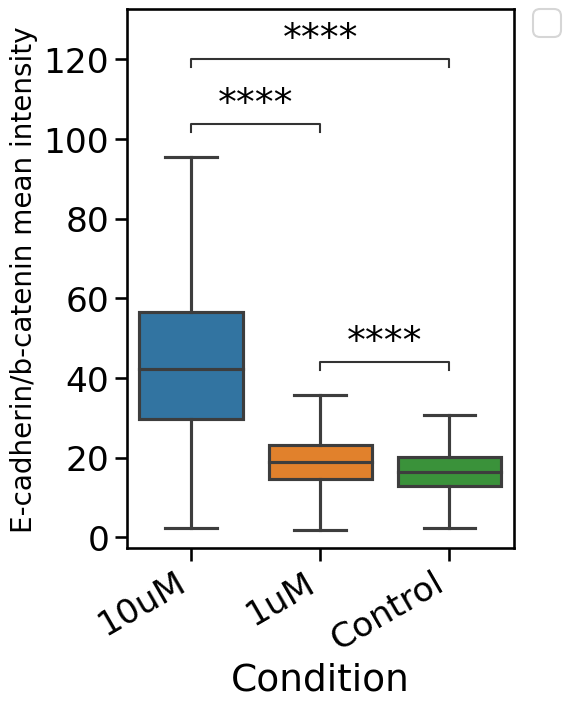

In [33]:
pairs = [('Control', '1uM'), ('Control', '10uM'), ('10uM', '1uM')]

with sns.plotting_context('talk', font_scale=1.5):
    fig, ax = plt.subplots(figsize=(5,7))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate()
    ax.set_ylabel('E-cadherin/b-catenin mean intensity', fontsize=20)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)